# Libraries.

In [2]:
# Essentials
import os
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-trained models.
from tensorflow.keras.applications import EfficientNetB0, InceptionV3

# Data augmentation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras necessities.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical

# Metrics.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tumor Class Object.

In [12]:
class TumorClassification():


  # Data Augmentation.
  def dataGeneration(self, generator, target_size, batch_size, shuffle):

    # Training.
    train = generator.flow_from_directory(
        '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/',
        target_size = target_size,
        batch_size = batch_size,
        subset = 'training',
        class_mode = 'categorical',
        shuffle = shuffle
        )
    print('Train shape: {}\n'.format(train.image_shape))


    # Validation based off training set.
    validation = generator.flow_from_directory(
        '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/',
        target_size = target_size,
        batch_size = batch_size,
        subset = 'validation'
        )
    print('Validation shape: {}\n'.format(validation.image_shape))


    # Test set from folder.
    test = generator.flow_from_directory(
        '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Testing/',
        target_size = target_size,
        batch_size = batch_size,
        shuffle = False
        )
    print('Test shape: {}\n'.format(test.image_shape))

    return train, validation, test




  # Pre-trained model.
  def knowledgeTransferModel(self, pre_model, include_top, input_shape):

    # EfficientNetB0 - Base layer.
    if pre_model == 'Efficient':
      EffNetB0 = EfficientNetB0(weights = 'imagenet', include_top = include_top, input_shape = input_shape)

      return EffNetB0

    # InceptionV3.
    elif pre_model == 'Inception':
      IncepV3 = InceptionV3(weights = 'imagenet', include_top = include_top, input_shape = input_shape)

      return IncepV3




  # Building the model.
  def buildModel(self, pre_model, pool, dropout, optimizer, loss, layers):

    model = pre_model.output

    # Choice of pooling layer.
    if pool == 'global': 
      model = GlobalAveragePooling2D()(model)

    else:
      model = MaxPooling2D()(model)

    # Dropout layer to prevent overfitting.
    model = Dropout(rate = dropout)(model)

    # Additional dense layers, if required.
    if layers[0] > 1:
      for i in range(layers[0]):
        model = Dense(layers[1], activation = 'relu')(model)

    # Output layer.
    model = Dense(4, activation = 'softmax')(model)
    model = Model(inputs = EffNetB0.input, outputs = model)

    # Choice of loss function, and optimizers.
    if loss == 'categorical':
      model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    elif loss == 'sparse':
      model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model




  # Defining callbacks.
  def callBacks(self, monitor, factor, patience, min_lr):

    tensorboard = TensorBoard(log_dir = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)')

    checkpoint = ModelCheckpoint('effnet.h5', monitor = monitor, save_best_only = True, mode = 'auto', verbose = 1)

    lr_reduction = ReduceLROnPlateau(monitor = monitor,
                                     factor = factor,
                                     patience = patience,
                                     min_lr = min_lr,
                                     mode = 'auto', verbose = 1)

    return tensorboard, checkpoint, lr_reduction




  # Visualising the model's performance during training.
  def historyPlots(self, history, metric):

    # Choice of metric to plot.
    if metric == 'accuracy':
      plt.plot(history.history['accuracy'], label = 'accuracy')
      plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
      plt.legend(loc = 'best')
      plt.xlabel('Epochs')
      plt.title('Training')
      plt.show()

    elif metric == 'loss':
      plt.plot(history.history['loss'], label = 'loss')
      plt.plot(history.history['val_loss'], label = 'val_loss')
      plt.legend(loc = 'best')
      plt.xlabel('Epochs')
      plt.title('Training')
      plt.show()




  # Plotting the confusion matrix.
  def confusionMatrix(self, X):

    pred = model.predict(X)
    classes = np.argmax(pred, axis = 1)
    
    cmd = ConfusionMatrixDisplay(confusion_matrix(X.classes, classes), display_labels = ['None', 'Glioma', 'Meningioma', 'Pituitary'])
    cmd.plot()

In [5]:
# Data Augmentation.
imgGen = ImageDataGenerator(
    rotation_range = 10, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1
    )

In [13]:
# Important Variables
batch_size = 32
input_shape = (250, 250, 3)
target_size = (250, 250)

# Initialising the class object.
tc = TumorClassification()

# Retrieving the data sets.
train, validation, test = tc.dataGeneration(imgGen, target_size, batch_size, True)


# Defining the pre-model.
EffNetB0 = tc.knowledgeTransferModel('Efficient', include_top = False, input_shape = input_shape)

# Building the model.
model = tc.buildModel(pre_model = EffNetB0, pool = 'global', dropout = 0.5, optimizer = 'adam', loss = 'categorical', layers = [0, 0])

# Callbacks.
tensorboard, checkpoint, lr_reduction = tc.callBacks(monitor = 'val_accuracy', factor = 0.5, patience = 3, min_lr = 0.0001)

Found 2585 images belonging to 4 classes.
Train shape: (250, 250, 3)

Found 285 images belonging to 4 classes.
Validation shape: (250, 250, 3)

Found 394 images belonging to 4 classes.
Test shape: (250, 250, 3)



# Convolution Model.

In [15]:
history = model.fit(train, validation_data = validation, epochs = 12, batch_size = 32, callbacks = [tensorboard, checkpoint, lr_reduction])

Epoch 1/12
81/81 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8441 
Epoch 1: val_accuracy improved from -inf to 0.76842, saving model to effnet.h5
81/81 [==============================] - 1936s 24s/step - loss: 0.4108 - accuracy: 0.8441 - val_loss: 0.7979 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 2/12
81/81 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9195
Epoch 2: val_accuracy improved from 0.76842 to 0.78246, saving model to effnet.h5
81/81 [==============================] - 58s 710ms/step - loss: 0.2296 - accuracy: 0.9195 - val_loss: 0.8242 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 3/12
81/81 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9366
Epoch 3: val_accuracy did not improve from 0.78246
81/81 [==============================] - 57s 703ms/step - loss: 0.1609 - accuracy: 0.9366 - val_loss: 0.8872 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 4/12
81/81 [==============================] - ETA: 0s - loss: 0.

In [ ]:
model.save('brain_model.h5')

In [ ]:
tc.historyPlots(history, 'accuracy')

## Evaluation

In [ ]:
tc.historyPlots(history, 'loss')

# Predictions

In [44]:
# Retrieving the unshuffled data sets.
train, validation, test = tc.dataGeneration(imgGen, target_size, batch_size, True)

Found 2585 images belonging to 4 classes.


## Training

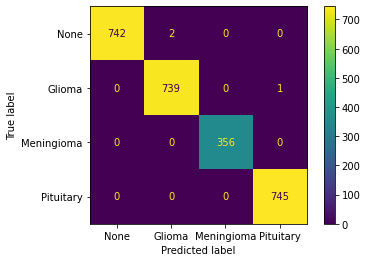

In [47]:
tc.confusionMatrix(train)

## Validation

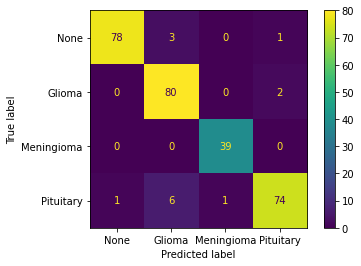

In [61]:
tc.confusionMatrix(validation)

## Entire Test Set.

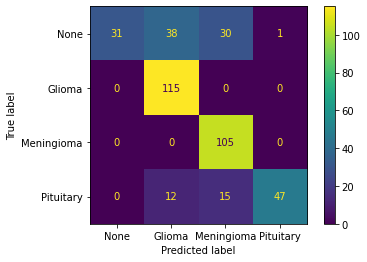

In [76]:
tc.confusionMatrix(test)